# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# import zipfile
# import os
# import pandas as pd

# with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/tm10007_ml/ecg')

# data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

In [ ]:
# Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import zscore
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# General packages
import zipfile
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import sklearn.metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.ensemble import RandomForestClassifier

# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Set RandomState for the entire notebook
rng = np.random.RandomState(42)

The number of samples: 827
The number of columns: 9001


In [23]:
# Load functions
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    '''
    This function plots the learning curve of a classifier using a 5-fold cross-validation
    Inputs:
    - X_train: 
    - y_train: labels
    - classifier: fitted classifier
    - scoring: supports all scoring methods from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html 
    and the 'error' scoring method, which is 1-accuracy
    - clf_type: is used for the title of the plot
    '''
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rng),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1) # error = 1 - accuracy
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1) # error = 1 - accuracy
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rng),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    # Plot figure
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def plot_roc_cv(X, y, n_splits=5):
    '''
    Performs a cross validation to train a number of models (equal to n_splits), calculates relevant metrics and plots the mean ROC curve.
    Returns the best classifier out of the folds with the corresponding training data
    '''
    y = data.iloc[:,-1]
    X = data.iloc[:,:-1]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)

    tprs = []
    aucs = []
    best_classifier = None
    best_auc = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        classifier = optimize_rf(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if viz.roc_auc > best_auc:
            best_auc = viz.roc_auc
            best_classifier = classifier
            best_X_train = X_train
            best_y_train = y_train

        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        fold_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")
        print(f"AUC Score: {fold_auc:.3f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")
    plt.show()
    return best_X_train, best_y_train, best_classifier


# Data visualisation

# SVM

# KNN

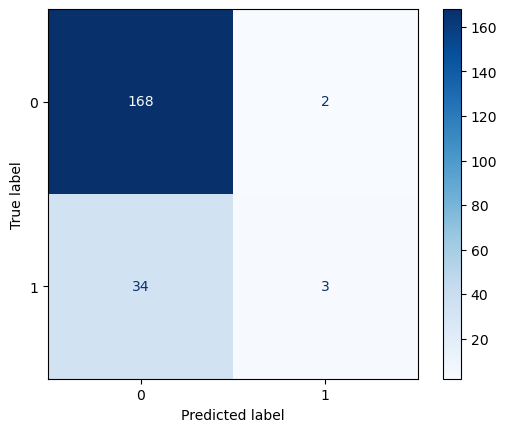

Accuracy:  0.826
Precision: 0.600
Recall:    0.081
F1 Score:  0.143
AUC Score: 0.614


In [ ]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=rng)

#Baseline model trainen, print roc_auc score 
knn= KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC Score: {auc:.3f}")

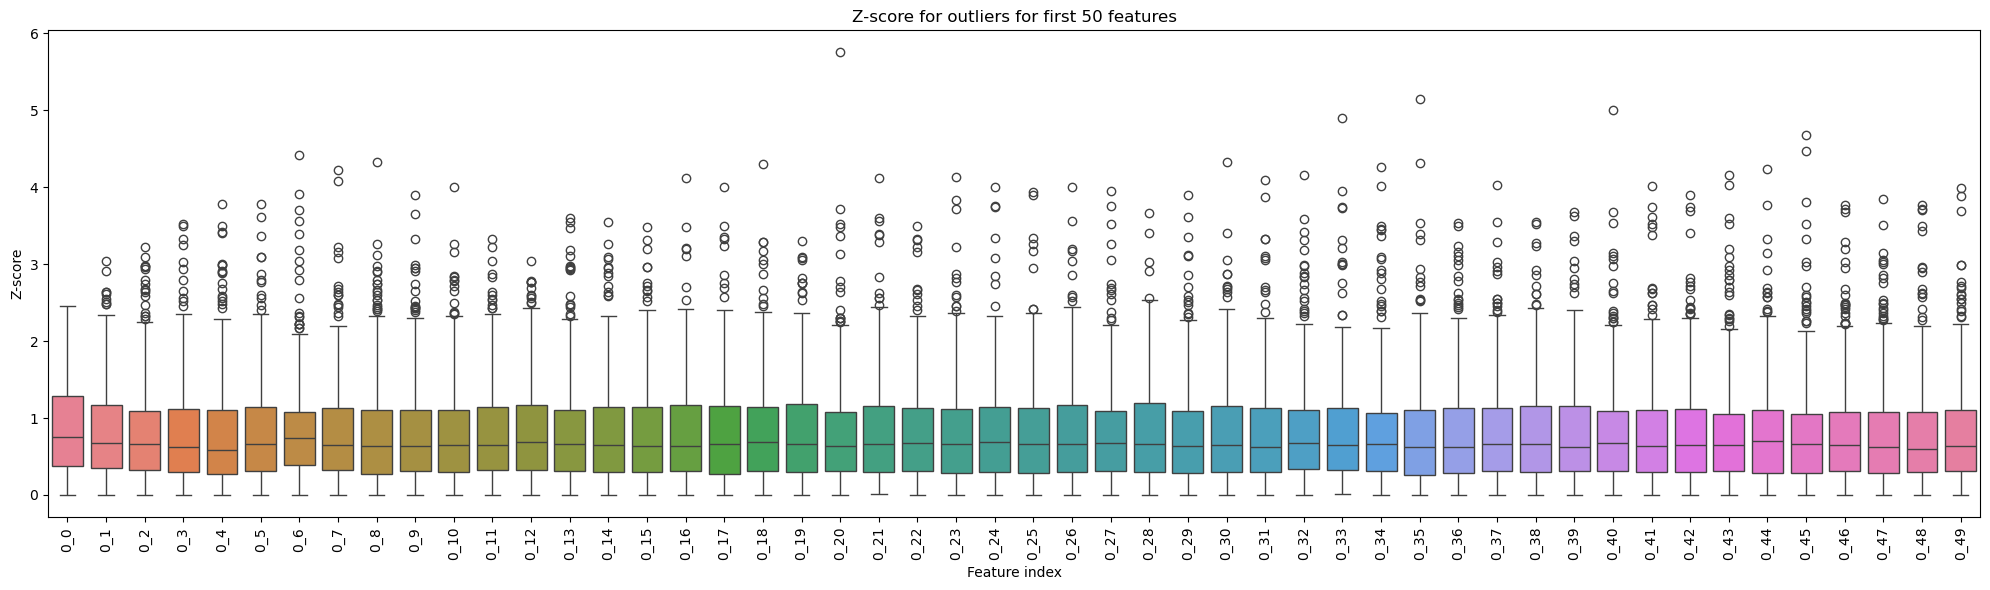

In [ ]:
#Preprocessing: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
#plot learning curve

# # Load functions
# def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
#     if scoring == 'error':
#         train_sizes, train_scores, test_scores = learning_curve(
#             classifier,
#             X_train,
#             y_train,
#             cv=StratifiedKFold(n_splits=5),
#             scoring='accuracy',
#             train_sizes=np.linspace(0.1, 1.0, 50),
#             n_jobs=-1
#         )
#         train_scores_mean = 1-np.mean(train_scores, axis=1)
#         train_scores_std = np.std(train_scores, axis=1)
#         test_scores_mean = 1-np.mean(test_scores, axis=1)
#         test_scores_std = np.std(test_scores, axis=1)
#     else:
#         train_sizes, train_scores, test_scores = learning_curve(
#             classifier,
#             X_train,
#             y_train,
#             cv=StratifiedKFold(n_splits=5),
#             scoring=scoring,
#             train_sizes=np.linspace(0.1, 1.0, 20),
#             n_jobs=-1
#         )
#         train_scores_mean = np.mean(train_scores, axis=1)
#         train_scores_std = np.std(train_scores, axis=1)
#         test_scores_mean = np.mean(test_scores, axis=1)
#         test_scores_std = np.std(test_scores, axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.title(f"Learning Curve ({clf_type})")
#     plt.xlabel("Number of training objectes")
#     plt.ylabel(scoring)

#     plt.grid()

#     plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")

#     plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                     test_scores_mean + test_scores_std, alpha=0.1, color="green")

#     plt.legend(loc="best")
#     plt.tight_layout()
#     plt.show()


c:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
247 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
247 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marti\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 654, in fit
    Xt = self._fit(X, y, r

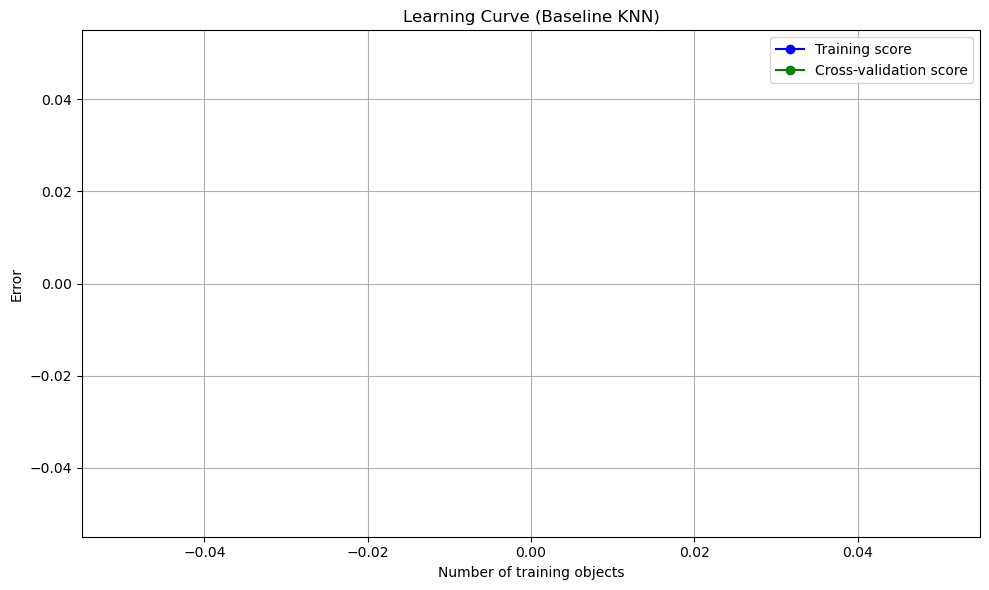

In [ ]:
# Stel hier je inputs in:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=400)),
    ('classifier', KNeighborsClassifier())
])

scoring = 'error'  
clf_type = 'Baseline KNN'
classifier = pipeline  

# Learning curve genereren
if scoring == 'error':
    train_sizes, train_scores, test_scores = learning_curve(
        classifier,
        X_train,
        y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 50),
        n_jobs=-1
    )
    train_scores_mean = 1 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(1 - train_scores, axis=1)
    test_scores_mean = 1 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(1 - test_scores, axis=1)
else:
    train_sizes, train_scores, test_scores = learning_curve(
        classifier,
        X_train,
        y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 20),
        n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

# Plotten
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve ({clf_type})")
plt.xlabel("Number of training objects")
plt.ylabel("Error" if scoring == 'error' else scoring)

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=400)),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)

#plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='error', clf_type='Baseline KNN, k=400')


KeyboardInterrupt: 

In [ ]:
#Hyperparameter selection, with feature selection k=800. 
knn = Pipeline([('scaler', RobustScaler()),('feature_selection', SelectKBest(mutual_info_classif, k=k)),('classifier', KNeighborsClassifier())])

parameters = {
    'feature_selection__k': np.arange(100, 9000, 300),
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)


Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=1300,
                             score_func=<function mutual_info_classif at 0x000001C15D24DA80>)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=19,
                                      weights='distance'))])
Best Score: 0.7138971299022698
best parameters: {'feature_selection__k': 1300, 'classifier__weights': 'distance', 'classifier__n_neighbors': 19, 'classifier__metric': 'chebyshev'}


In [ ]:
# In the code above is shown there are 5800 features selected. For the rest of the code we use these features
knn = Pipeline([('scaler', RobustScaler()),('feature_selection', SelectKBest(mutual_info_classif, k=800)),('classifier', KNeighborsClassifier())])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)


Best estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectKBest(k=800,
                             score_func=<function mutual_info_classif at 0x000001C15D24DA80>)),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_neighbors=21))])
Best Score: 0.7267114524538854
best parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 21, 'classifier__metric': 'chebyshev'}


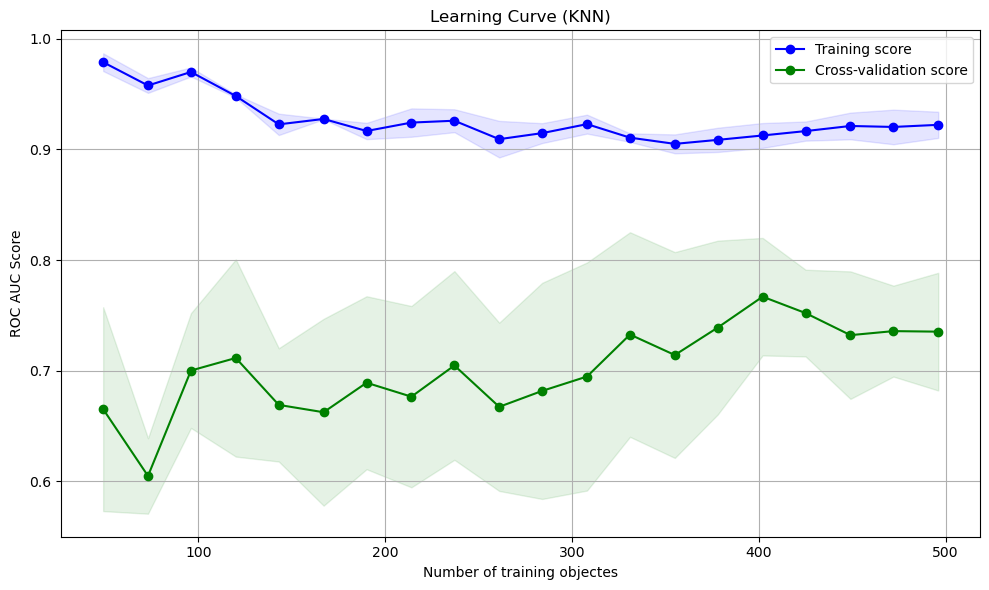

In [ ]:
#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 20),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (KNN)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Random Forest

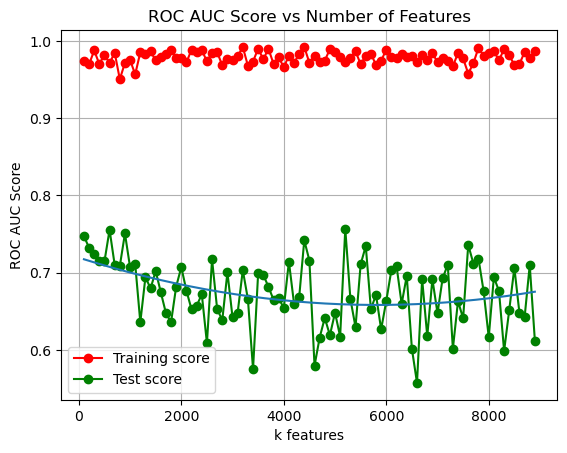

In [18]:
# Since the dataset contains 9000 features, it is likely that a large part of the features in the dataset contains no useful information. 
# If RF randomly selects these irrelevant features, we would introduce noise to our model and thus decrease the model performance. 
# To test this, the area under the receiver operating characteristics curve (ROC AUC) score was plotted for different numbers of features, 
# using a simple RF classifier (n_estimators=10, max_depth=10) and a train-test-split (test size 0.25).

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=rng)

train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)

# For each k features in the list, train a RF classifier and calculate the AUC score
for k in k_list:
    rf = Pipeline([
                ('feature_selection', SelectKBest(f_classif, k=k)), 
                ('rfc', RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=rng))
                ])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Fit a trendline through the points of the test scores (since that is what we're interested in)
poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.set_title('ROC AUC Score vs Number of Features')
ax.set_xlabel('k features')
ax.set_ylabel('ROC AUC Score')
ax.legend()


In [27]:
# For the Random Forest classifier, we decided to optimize the number of features (k), the number of estimators (n_estimators),
# minimum number of samples required for a split (min_samples_split), minimum number of samples required for a leaf (min_samples_leaf), 
# maximum depth of each tree (max_depth), function to measure the quality of a split (criterion), 
# and whether bootstrapping is used to train the trees (bootstrap).

def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=rng, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 15, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=rng), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=rng
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_


Best Parameters: {'feature_selection__k': 150, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 45, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8105064769263347
Accuracy:  0.795
Precision: 0.429
Recall:    0.517
F1 Score:  0.469
AUC Score: 0.742
Best Parameters: {'feature_selection__k': 170, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7990160882861321
Accuracy:  0.825
Precision: 0.514
Recall:    0.633
F1 Score:  0.567
AUC Score: 0.819
Best Parameters: {'feature_selection__k': 130, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8019113149847

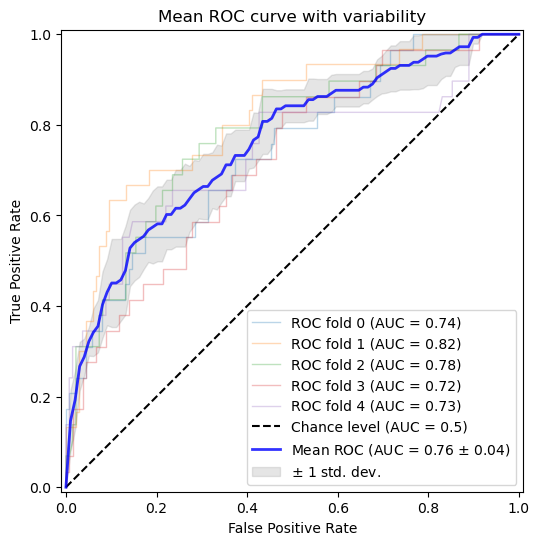

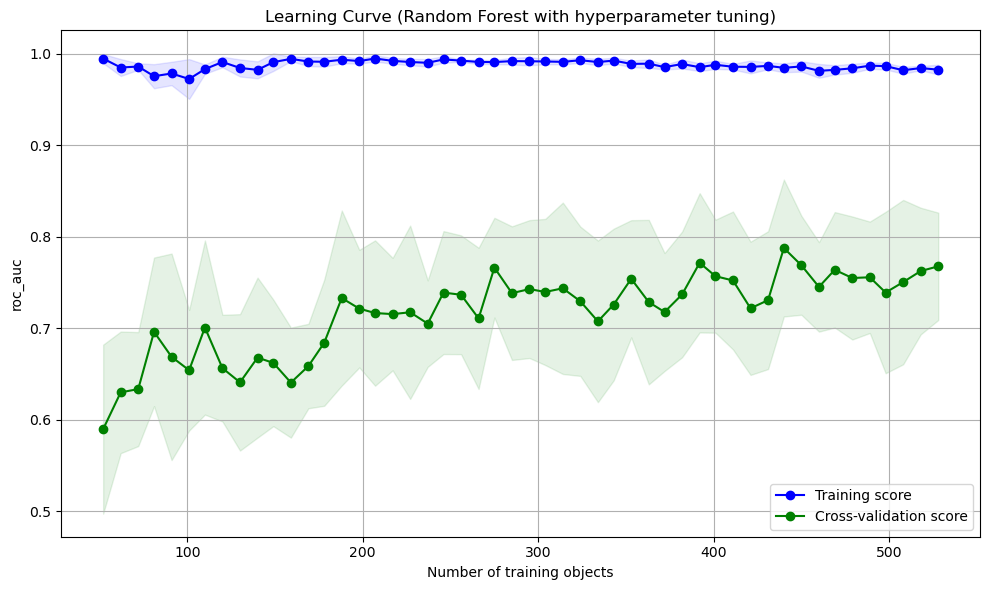

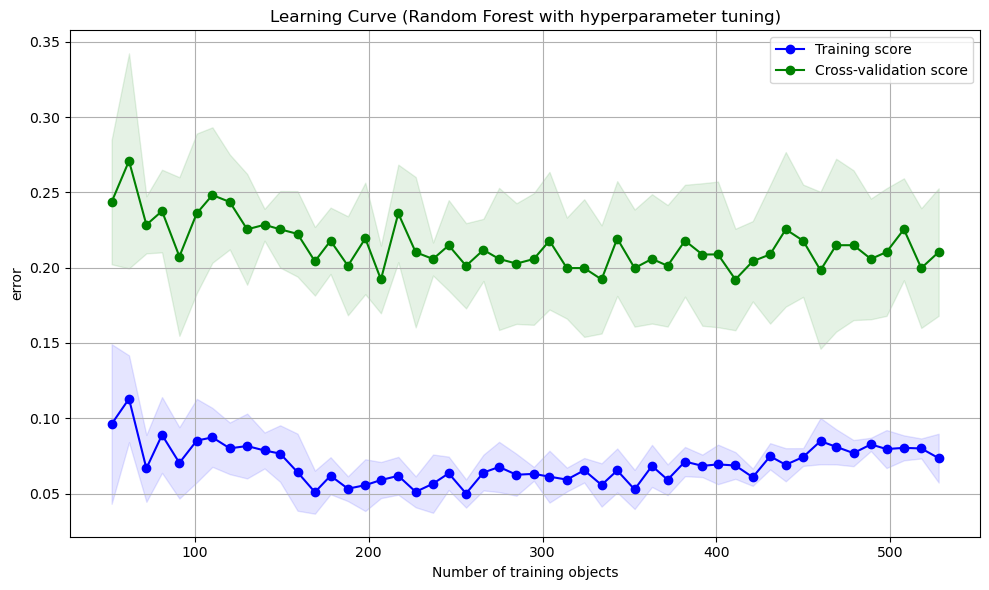

In [30]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


# Unused

# Baseline RandomForest model
To check the performance of a simple model, a RandomForestClassifier with 10 estimators and a max depth of 5 was used. The same model was used to plot the AUC score vs the number of features.

The learning curve shows that the addition of more samples does not significantly change the training error after around 400 samples. The cross-validation score barely decreases when adding more samples, indicating that the model is overfit.

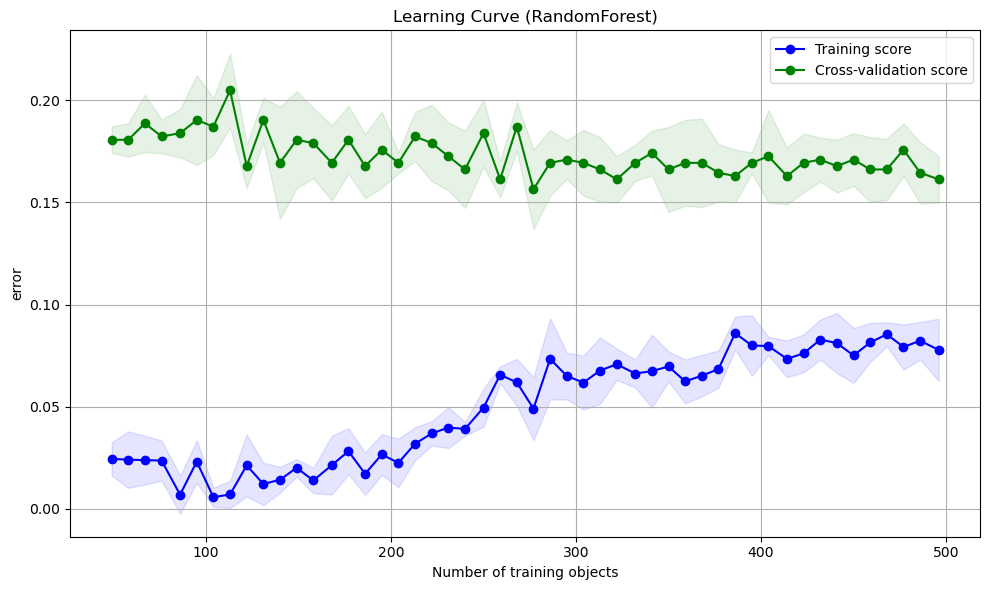

In [ ]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1)
rf.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='RandomForest')

Best Parameters: {'feature_selection__k': 125, 'classifier__n_estimators': 30, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 14, 'classifier__max_depth': 16, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7936484940930826
Accuracy:  0.880
Precision: 0.667
Recall:    0.621
F1 Score:  0.643
AUC Score: 0.810
Best Parameters: {'feature_selection__k': 925, 'classifier__n_estimators': 20, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 16, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.814745379603776
Accuracy:  0.813
Precision: 0.474
Recall:    0.300
F1 Score:  0.367
AUC Score: 0.743
Best Parameters: {'feature_selection__k': 375, 'classifier__n_estimators': 24, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 12, 'classifier__max_depth': 16, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.78002260337721

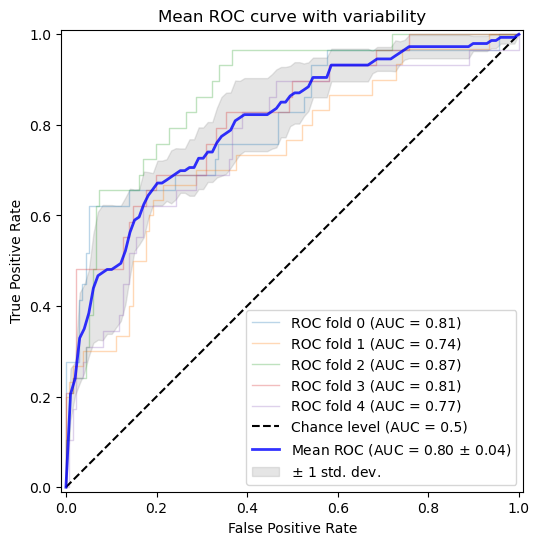

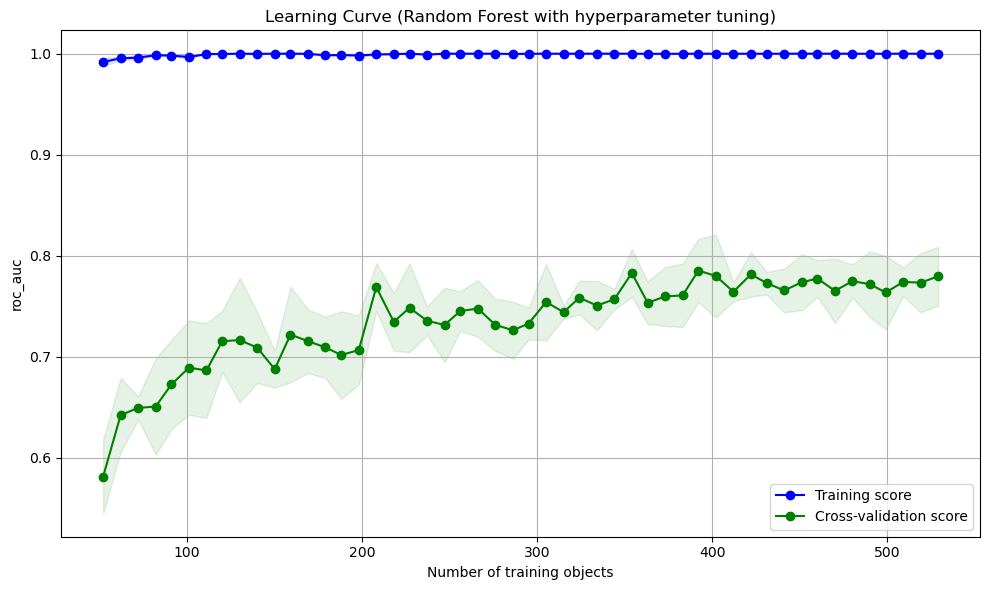

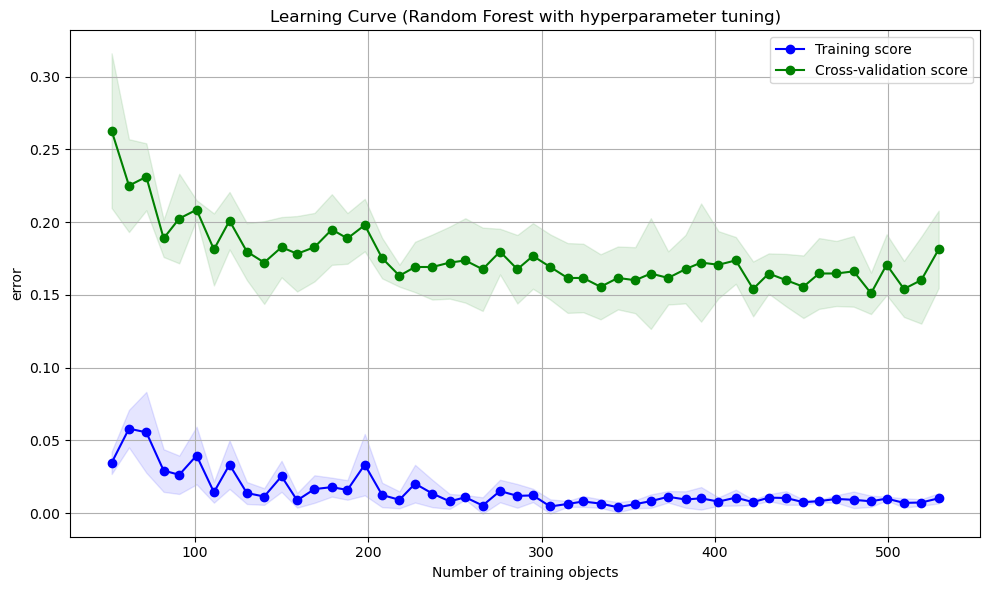

In [ ]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 2500, 25), # [300, 400, 500, 9000],
        'classifier__n_estimators': np.arange(10, 40, 2), # [30, 40, 50],
        'classifier__min_samples_split': np.arange(10, 20, 2), # [5, 10, 15],
        'classifier__min_samples_leaf': np.arange(10, 20, 2),
        'classifier__max_depth': np.arange(6, 20, 2), # [5, 10, 15, None],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


Best Parameters: {'feature_selection__k': 850, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 45, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7798401512801194
Accuracy:  0.801
Precision: 0.447
Recall:    0.586
F1 Score:  0.507
AUC Score: 0.787
Best Parameters: {'feature_selection__k': 950, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 45, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8092308203696316
Accuracy:  0.753
Precision: 0.296
Recall:    0.267
F1 Score:  0.281
AUC Score: 0.670
Best Parameters: {'feature_selection__k': 200, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7565383592607

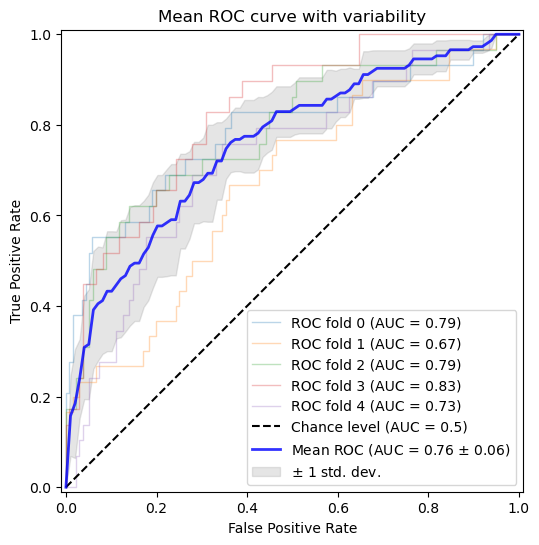

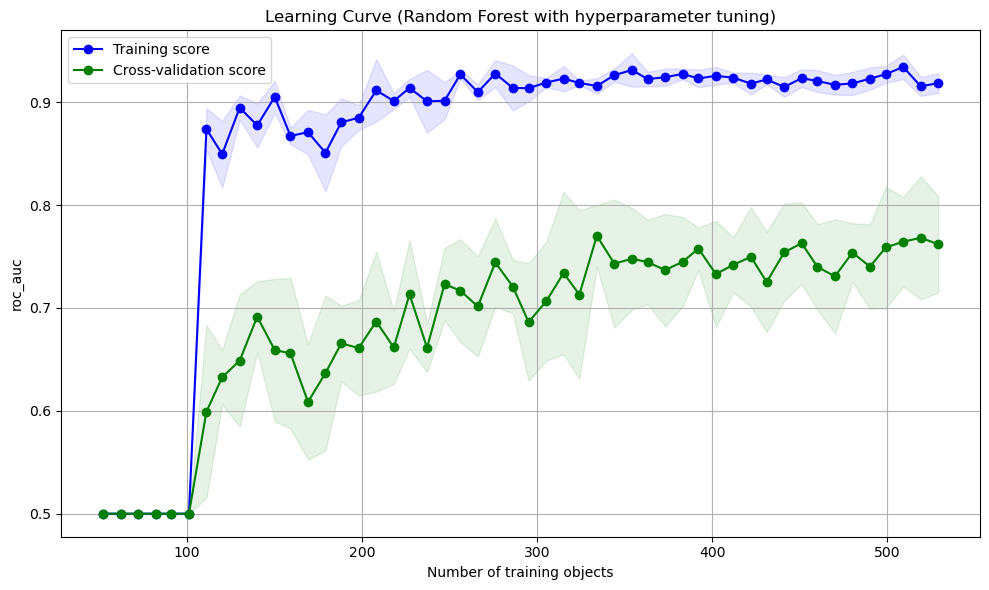

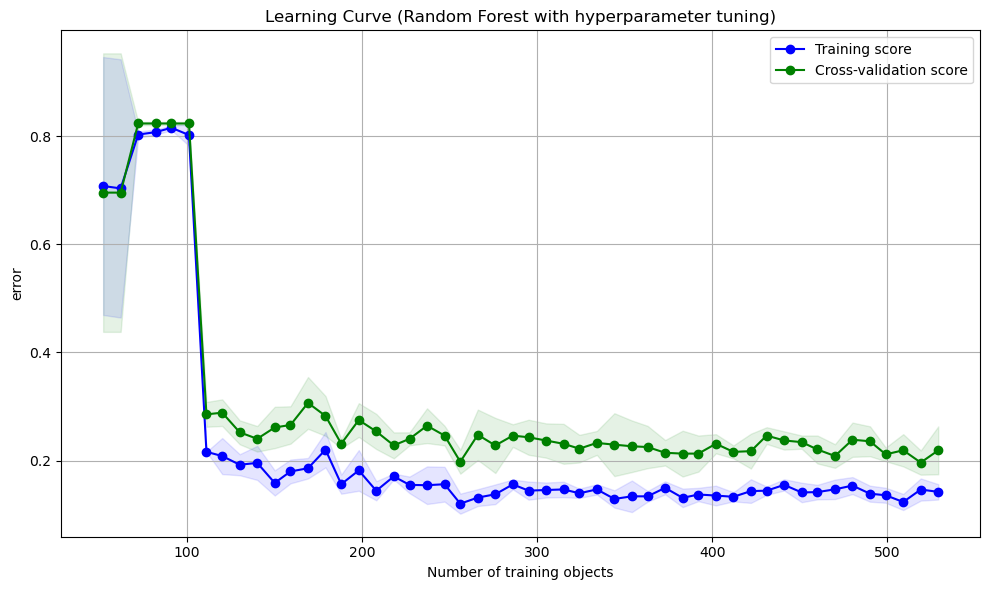

In [ ]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 1000, 50),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')

Best Parameters: {'feature_selection__k': 110, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 45, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7756461845105309
Accuracy:  0.753
Precision: 0.364
Recall:    0.552
F1 Score:  0.438
AUC Score: 0.781
Best Parameters: {'feature_selection__k': 120, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.0001, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.8073095333067413
Accuracy:  0.765
Precision: 0.378
Recall:    0.467
F1 Score:  0.418
AUC Score: 0.720
Best Parameters: {'feature_selection__k': 130, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 35, 'classifier__min_impurity_decreas

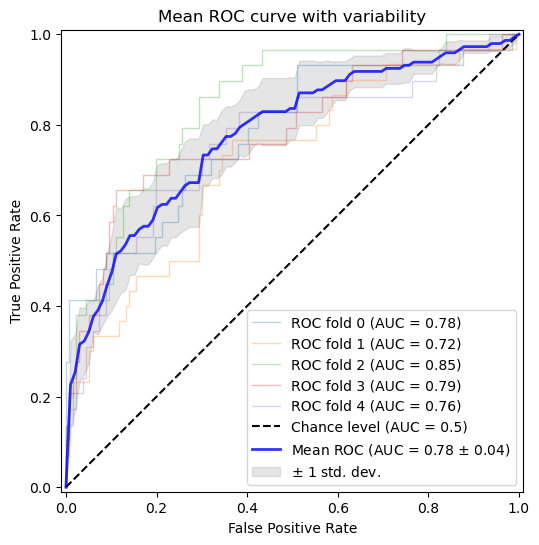

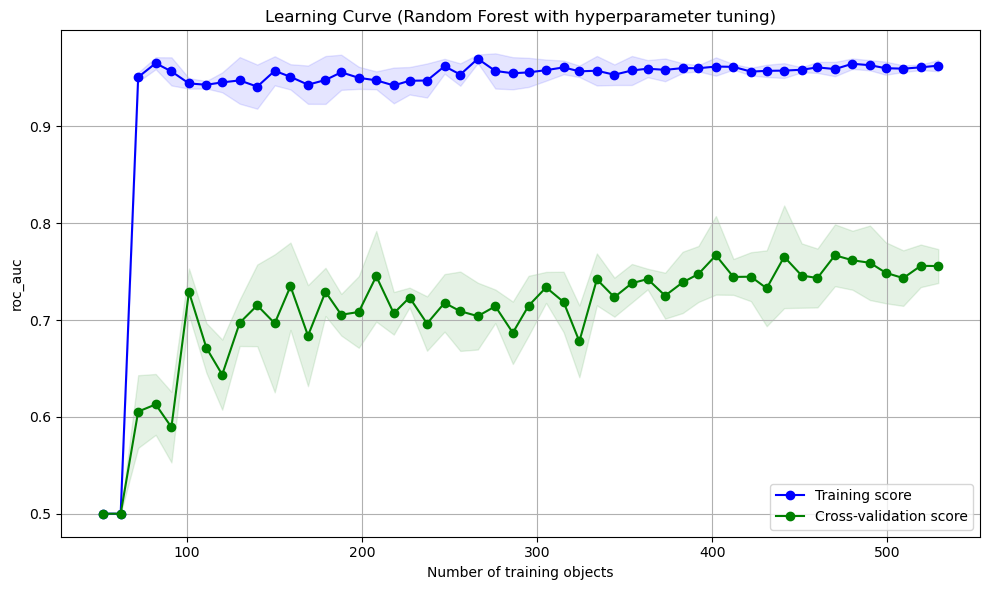

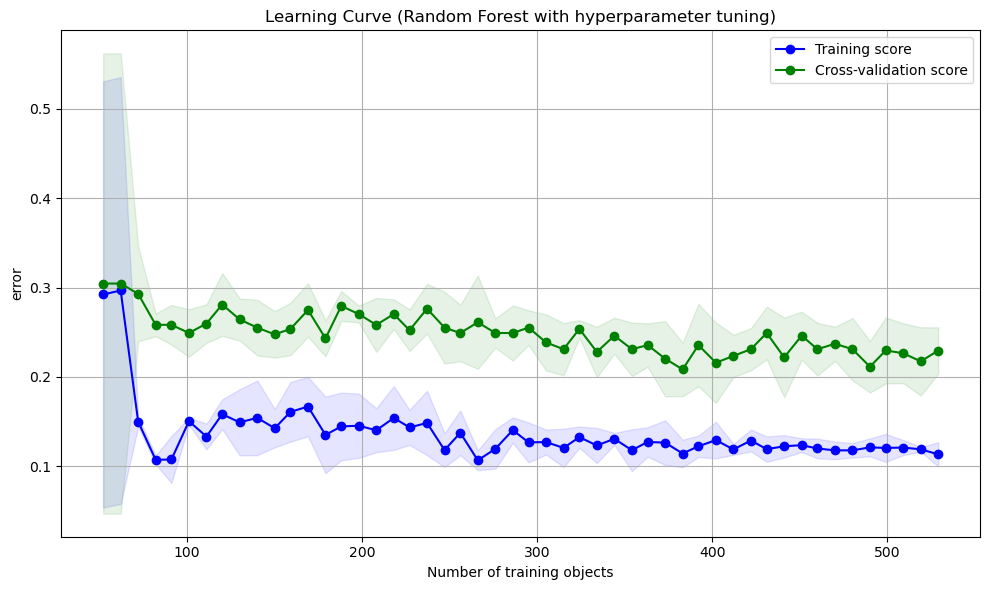

In [ ]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')